# Описание проекта

Банк испытывает проблемы удержания клиентов. Привлекать новых клиентов дорого, дешевле удержать тех, про которых уже что-то известно. Необходимо проанализировать клиентов банка и выделить сегменты клиентов, которые склонны уходить из банка. 

**Цель исследования:** снижение оттока клиентов.

**Задача:** выделить однородные сегменты клиентов, максимально покрывающие проблемные зоны.

**Заказчик:** отдел маркетинга.

**План исследования:**

1. [Загрузка данных, изучение общей информации](#1)


2. [Предобработка данных](#2)

- Приведение к нужным типам данным, переименование колонок
- Кодирование категориальных переменных
- Обработка дубликатов
- Обработка пропусков

3. [EDA](#3)
- Построение матрицы корреляции признаков, определение признаков, влияющих на отток
- Построение гистограммы по каждому признаку в разрезе отточных и не отточных клиентов
- Сравнение портретов клиентов по средним/медианным/модальным значениям признаков
- Проверка стат.гипотез

4. [Выделение сегментов клиентов:](#4)
- выбор ключевых признаков, влияющих на отток
- сегментирование отточных клиентов
- проверка размерности (значимости) сегментов
- приоритезация сегментов

5. [Формулирование рекомендаций по удержанию клиентов по приоритетным сегментам](#5)

## Загрузка данных, изучение общей информации
<a id='1'></a>

In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from statistics import mode
from scipy import stats as st
from itertools import combinations

pd.set_option('display.max_colwidth', 0)

In [2]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F"
df = pd.read_csv(path)

display(df.head())
print(df.info())
display(df.describe())

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB
None


,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,10000.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.409400,42.837100,2.627600,8.277943e+05,1.874100,0.680400,0.523500,1.478669e+05,0.182200
std,33708.23812,65.796312,12.128507,1.980836,1.980614e+06,0.799946,0.466345,0.499472,1.393885e+05,0.386029
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,801.000000,34.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


In [3]:
print(df['city'].value_counts(), '\n')
print(df['gender'].value_counts())

Ярославль    5906
Рыбинск      2663
Ростов       1431
Name: city, dtype: int64 

М    5008
Ж    4992
Name: gender, dtype: int64


В датафрейме содержится информация о 10000 клиентах, по которым доступно 11 признаков. Для удобства приведем названия столбцов к snake_case, столбец `USERID` используем в качестве индекса. <br>
В столбце `balance` есть пропуски, обработаем их на следующих шагах. Использованы корректные типы данных.<br>
Ярко выраженных аномалий, выбросов не обнаружено.

## Предобработка данных
<a id='2'></a>

In [4]:
df.columns = df.columns.str.lower()
df.set_index('userid', inplace=True)

In [5]:
# кодирование столбца gender через замену значений
to_replace = {'М' : 1, 'Ж' : 0}
df = df.replace(to_replace)

In [6]:
# кодирование столбца city через One Hot Encoding
df = pd.get_dummies(df, columns=['city'])
df.head()

,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль
userid,,,,,,,,,,,,,
183012,850.0,0,25,1,59214.82,2,0,1,75719.14,1,0,1,0
146556,861.0,0,37,5,850594.33,3,1,0,86621.77,0,0,1,0
120722,892.0,0,30,0,NaN,1,1,1,107683.34,0,0,1,0
225363,866.0,0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1
157978,730.0,1,34,5,174.00,1,1,0,67353.16,1,0,0,1


In [7]:
df.duplicated().sum()

1

In [8]:
df = df.drop_duplicates()

### Обработка пропусков в столбце `balance`

In [10]:
# доля пропущенных значений
df['balance'].isna().sum() / df.shape[0]

0.2294229422942294

In [11]:
# средние значения признаков по строкам с пропусками и без пропусков
pd.DataFrame(columns = ['df'], data = df.mean()) \
.join(pd.DataFrame(columns = ['df_without_NaNs'], data = df[df['balance'].notna()].mean()))

,df,df_without_NaNs
score,848.401340,843.739260
gender,0.500750,0.483452
age,42.838084,43.131343
equity,2.627863,3.395068
balance,827794.306510,827794.306510
products,1.874187,2.086178
credit_card,0.680368,0.640104
last_activity,0.523552,0.515769
est_salary,147843.483003,124501.872366
churn,0.182218,0.234783


In [12]:
df.query('balance == 0')

,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль
userid,,,,,,,,,,,,,
179831,730.0,1,18,0,0.0,2,1,1,64548.33,0,0,0,1
148456,813.0,1,20,2,0.0,2,1,0,23876.51,0,0,0,1


Доля отточных клиентов по датафрейму с пропусками и без отличается на 5 п.п. Признаки также имеют существенные различия. Учитывая высокую долю пропущенных значений, удаление строк с NaN может исказить данные. Можно предположить, что отсутствующая информация о балансе говорит о нулевом балансе и NaN следует заменить на нули. Однако в датафрейме содержатся записи именно с нулевым балансом. Возможные причины пропусков:
- техническая ошибка при выгрузке данных;
- данные скрыты намеренно (например, это VIP клиенты, доступ к остаткам по счету ограничен);
- у клиента нет открытых счетов в банке. 

Посмотрим, прослеживается ли зависимость между балансом и другими признаками. Также выведем корреляцию между оттоком и признаками, чтобы посмотреть, насколько важен признак balance для дальнейшего анализа.

In [13]:
def plot_corr(feature):
    plt.figure(figsize=(12,5))
    sns.heatmap(df.corr().loc[:,[feature]].drop(feature).sort_values(feature), 
            annot=True, fmt='.0%', cmap='vlag', center=0, ax=plt.subplot(1,2,1))
    sns.heatmap(df.corr().loc[:,['churn']].drop('churn').sort_values('churn'), 
            annot=True, fmt='.0%', cmap='vlag', center=0, ax=plt.subplot(1,2,2))
    plt.tight_layout()
    plt.show()

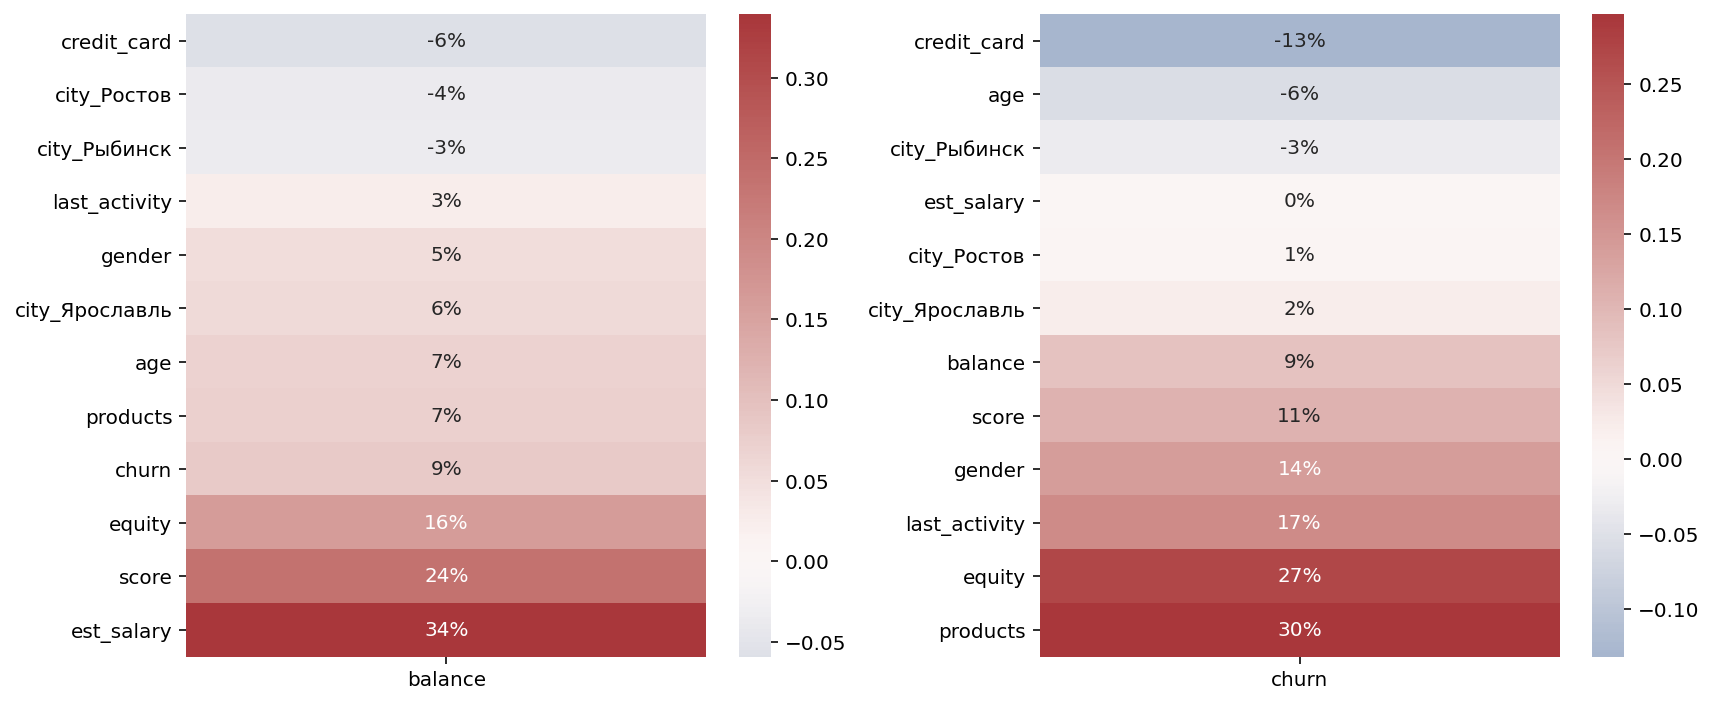

In [14]:
plot_corr('balance')

У баланса существует умеренная прямая зависимость между заработной платой, слабая зависимость между баллам кредитного скоринга и имущественным положением. На уровень оттока баланс практически не влияет. В целом от этого признака возможно избавиться путем удаления столбца. Однако попробуем принять гипотезу о том, что данные отсутствуют по определенной причине (Missing Not At Random). Следовательно, можно добавить индикатор отсутствующего баланса в качестве новой фичи и проанализировать степень влияния на отток.

### Добавление индикатора отсутствующего баланса

In [16]:
# используем MissingIndicator, строка с пропуском будет помечаться как 1
indicator = MissingIndicator()
missing_balance = indicator.fit_transform(df)
df['missing_balance'] = missing_balance

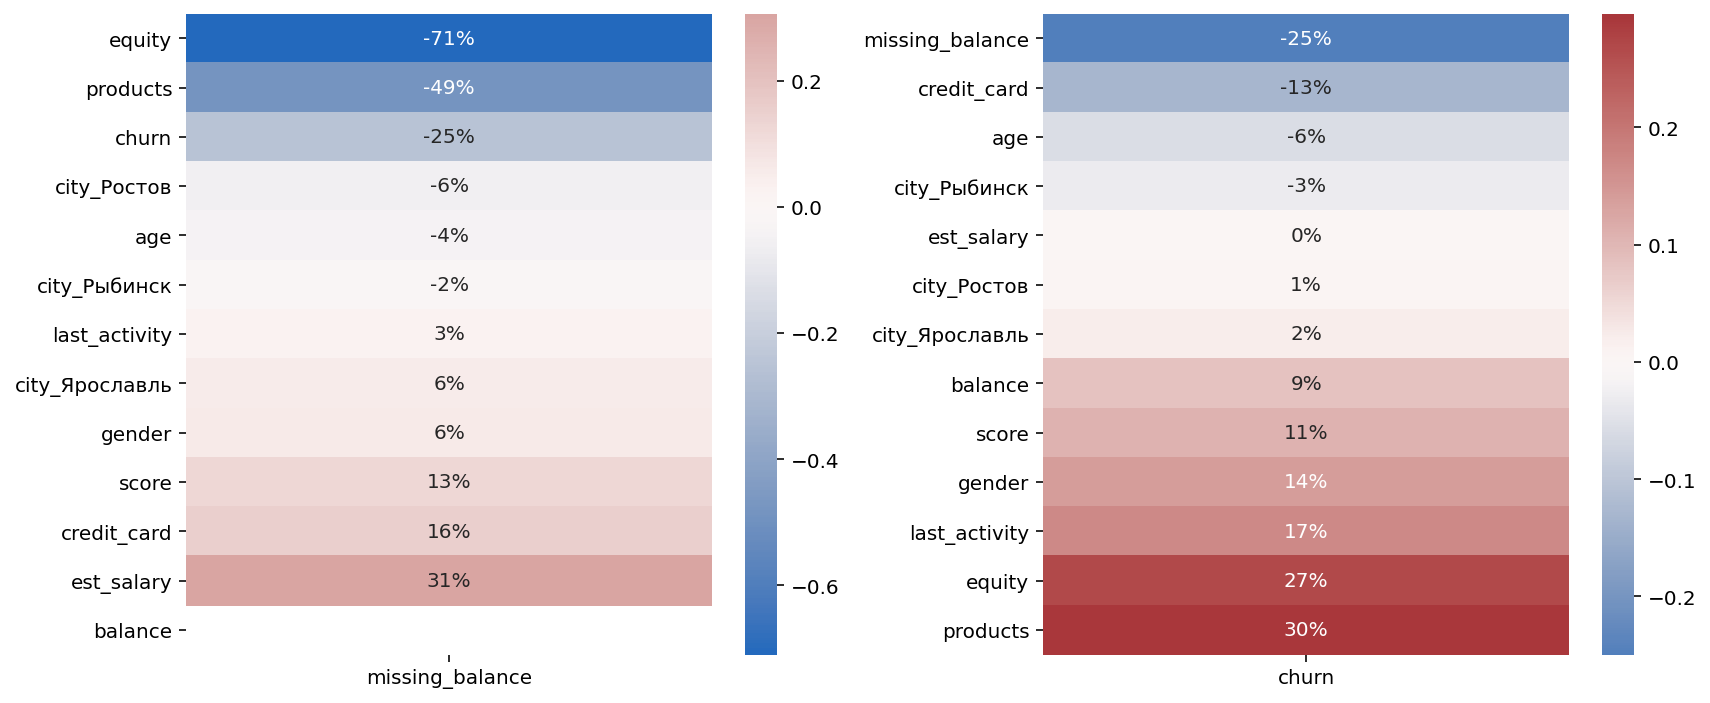

In [17]:
plot_corr('missing_balance')

Как видим, существует высокая обратная зависимость между имущественным положением `equity` и отсутствующим балансом: чем ниже оценка активов клиента, тем чаще нет информации о балансе. Кроме того, заметна обратная зависимость и с количеством продуктов. Возможно, у таких клиентов действительно нет расчетного счета в банке, они пользуются малым количеством продуктов, например, только кредитной картой. Примечательно, что факт отсутствующего баланса обратно зависим с оттоком.

Учитывая, что у баланса есть небольшая зависимость от ряда признаков, попробуем предсказать отсутствующие данные с попощью алгоритма K-Nearest Neighbors. Алгоритм будет искать наиболее похожие по другим фичам строки к строке с пропущенным балансом, вычислять среднее значение баланса в таких строках и заполнять ими пропуски.

### Замена на K-Nearest Neighbors

In [18]:
impute = KNNImputer(n_neighbors=5)
prediction = impute.fit_transform(df)

In [19]:
df_pred = pd.DataFrame(columns=df.columns, data=prediction, index=df.index)
display(df_pred.head())
print(df_pred.info())

,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,missing_balance
userid,,,,,,,,,,,,,,
183012,850.0,0.0,25.0,1.0,59214.82,2.0,0.0,1.0,75719.14,1.0,0.0,1.0,0.0,0.0
146556,861.0,0.0,37.0,5.0,850594.33,3.0,1.0,0.0,86621.77,0.0,0.0,1.0,0.0,0.0
120722,892.0,0.0,30.0,0.0,769418.66,1.0,1.0,1.0,107683.34,0.0,0.0,1.0,0.0,1.0
225363,866.0,0.0,51.0,5.0,1524746.26,2.0,0.0,1.0,174423.53,1.0,0.0,0.0,1.0,0.0
157978,730.0,1.0,34.0,5.0,174.00,1.0,1.0,0.0,67353.16,1.0,0.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 183012 to 96267
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   score            9999 non-null   float64
 1   gender           9999 non-null   float64
 2   age              9999 non-null   float64
 3   equity           9999 non-null   float64
 4   balance          9999 non-null   float64
 5   products         9999 non-null   float64
 6   credit_card      9999 non-null   float64
 7   last_activity    9999 non-null   float64
 8   est_salary       9999 non-null   float64
 9   churn            9999 non-null   float64
 10  city_Ростов      9999 non-null   float64
 11  city_Рыбинск     9999 non-null   float64
 12  city_Ярославль   9999 non-null   float64
 13  missing_balance  9999 non-null   float64
dtypes: float64(14)
memory usage: 1.4 MB
None


In [20]:
df_pred[df_pred.columns.difference(['balance', 'est_salary'])] = \
df_pred[df_pred.columns.difference(['balance', 'est_salary'])].astype(int)

Сравним распределения баланса до и после обработки пропусков:

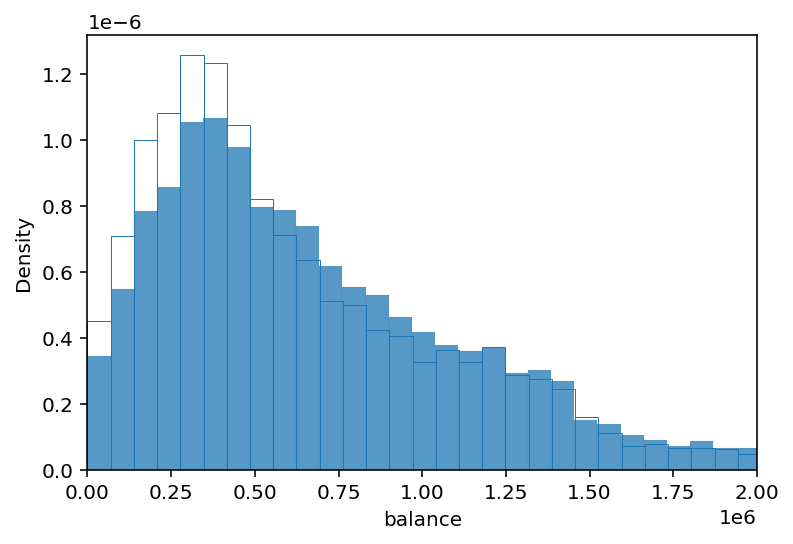

In [21]:
fig, ax = plt.subplots()
sns.histplot(x='balance', data=df, stat='density', ax=ax, fill=False)
sns.histplot(x='balance', data=df_pred, stat='density', ax=ax)
plt.xlim(0,2000000)
plt.show()

Обработка пропусков не привела к значимым изменениями в характере распределения.

## EDA
<a id='3'></a>

Построим матрицу корреляции признаков, влияющих на отток, после обработки пропусков.

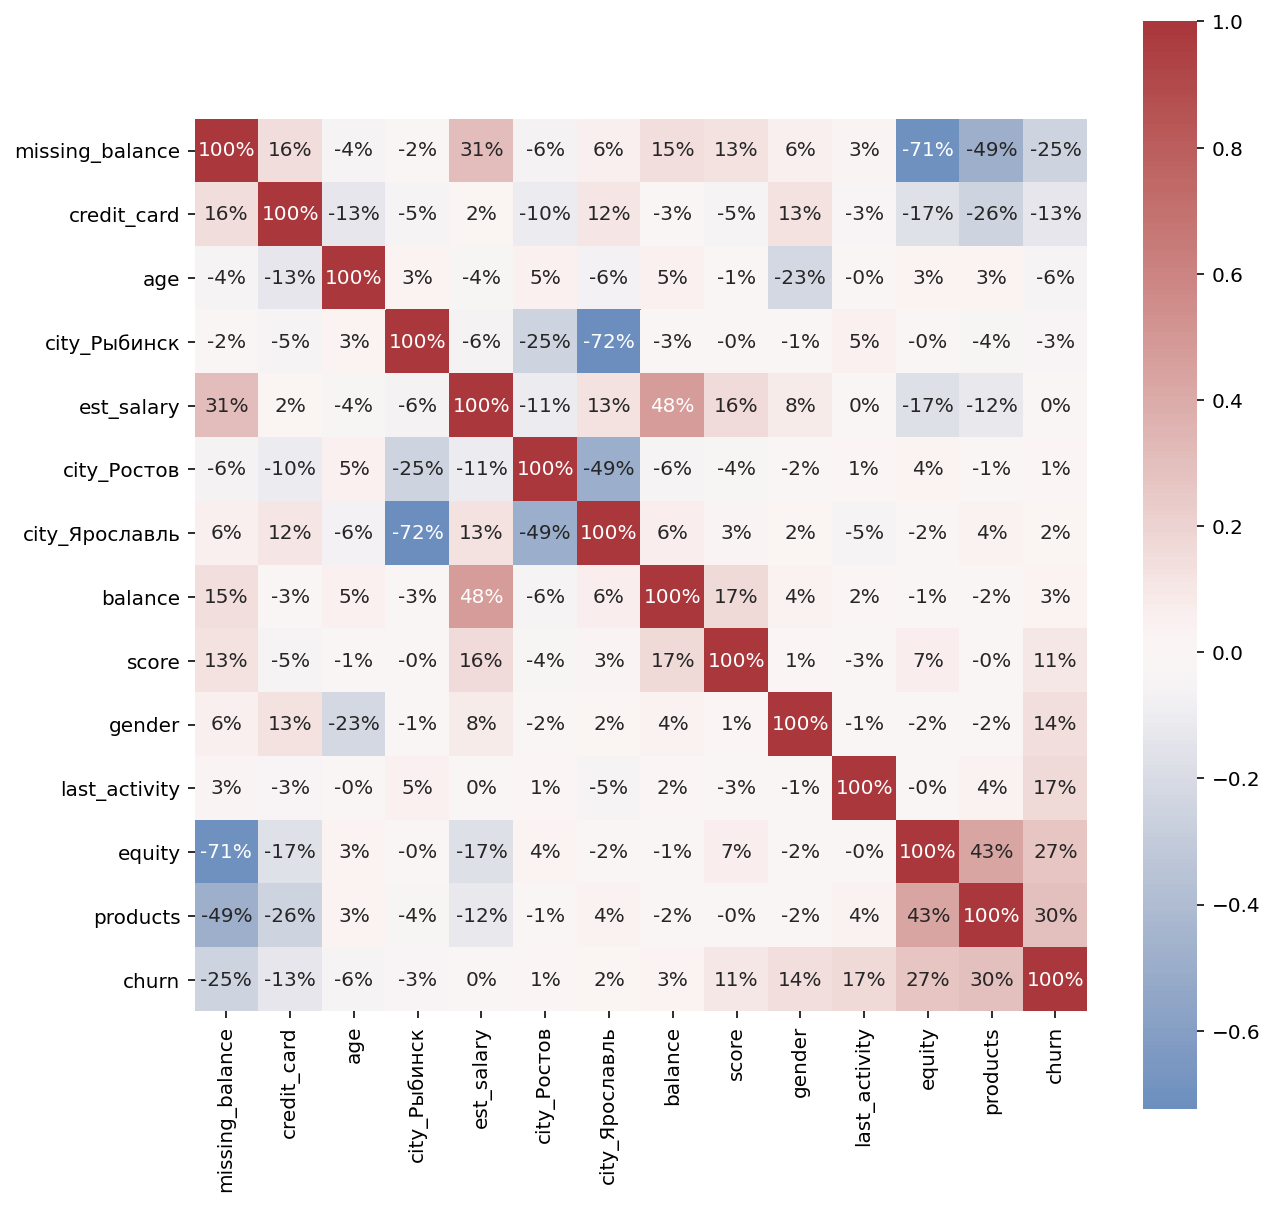

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(df_pred.corr().sort_values('churn').T.sort_values('churn').T, 
            annot=True, fmt='.0%', cmap='vlag', center=0, square=True)

plt.show()

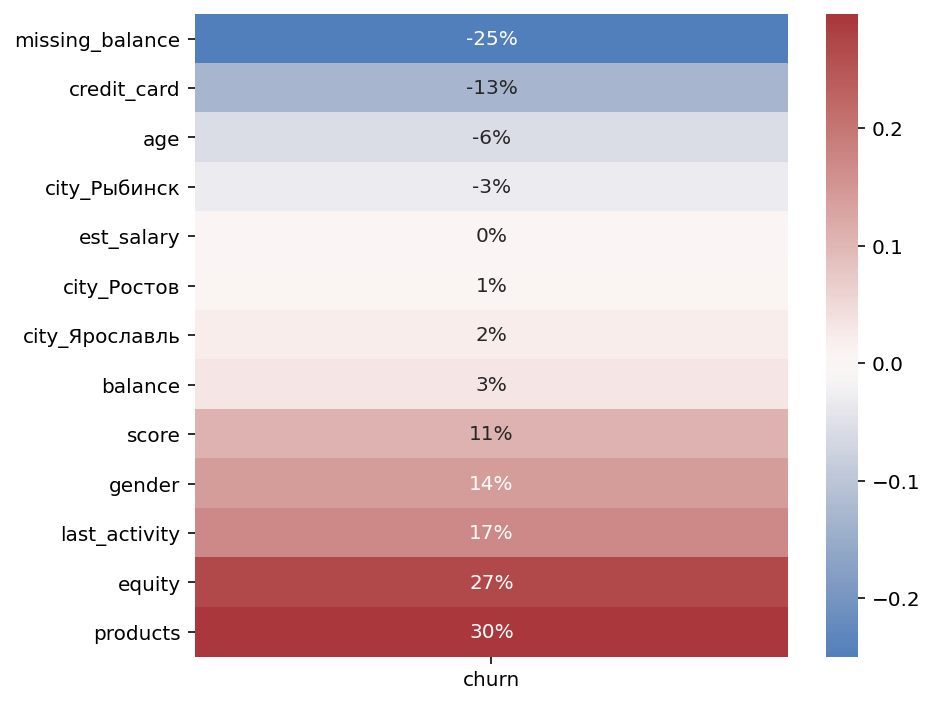

In [23]:
plt.figure(figsize=(12,5))
sns.heatmap(df_pred.corr().loc[:,['churn']].drop('churn').sort_values('churn'), 
            annot=True, fmt='.0%', cmap='vlag', center=0, ax=plt.subplot(1,2,1))
plt.tight_layout()
plt.show()

Построим гистограммы по каждому признаку в разрезе отточных и не отточных клиентов.

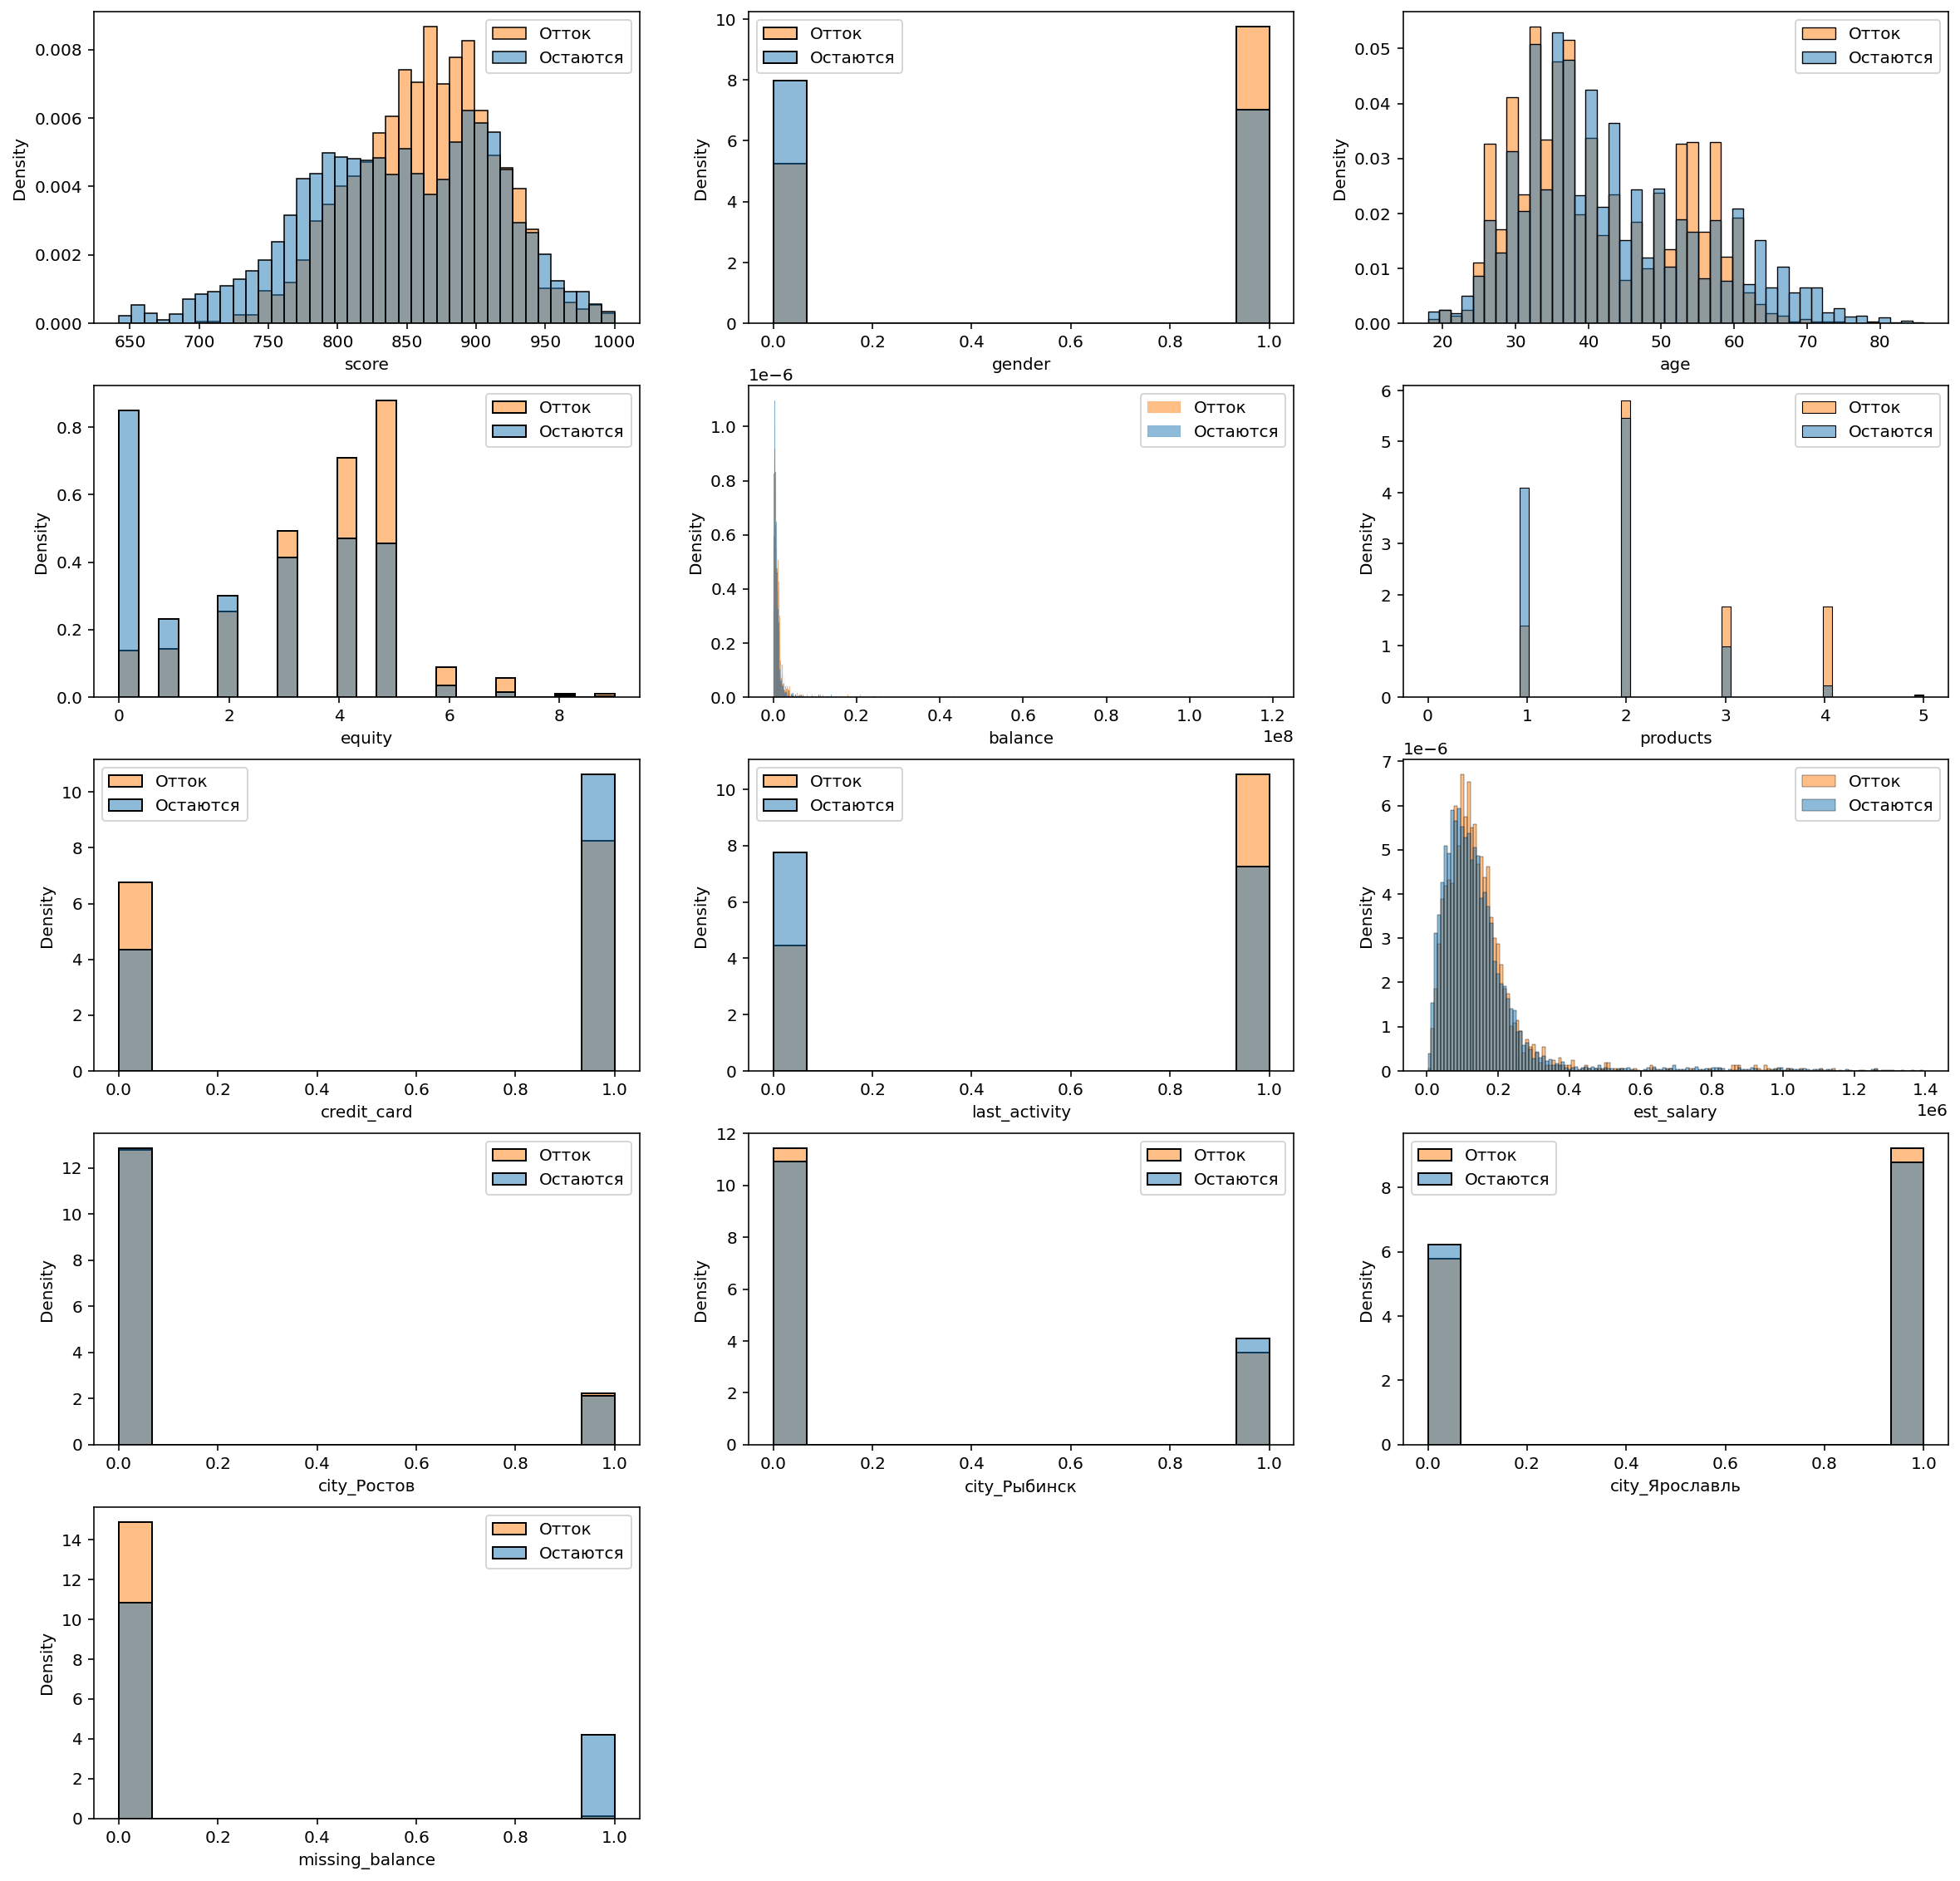

In [24]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(df_pred.drop('churn', axis=1).columns):
    sns.histplot(x=feature, 
                 data=df_pred, 
                 stat='density', 
                 hue='churn', 
                 common_norm=False, 
                 ax=plt.subplot(5, 3, i+1))
    plt.legend(labels=['Отток', 'Остаются'])

plt.show()

Отдельно посмотрим на распределение баланса и дохода в увеличенном масштабе.

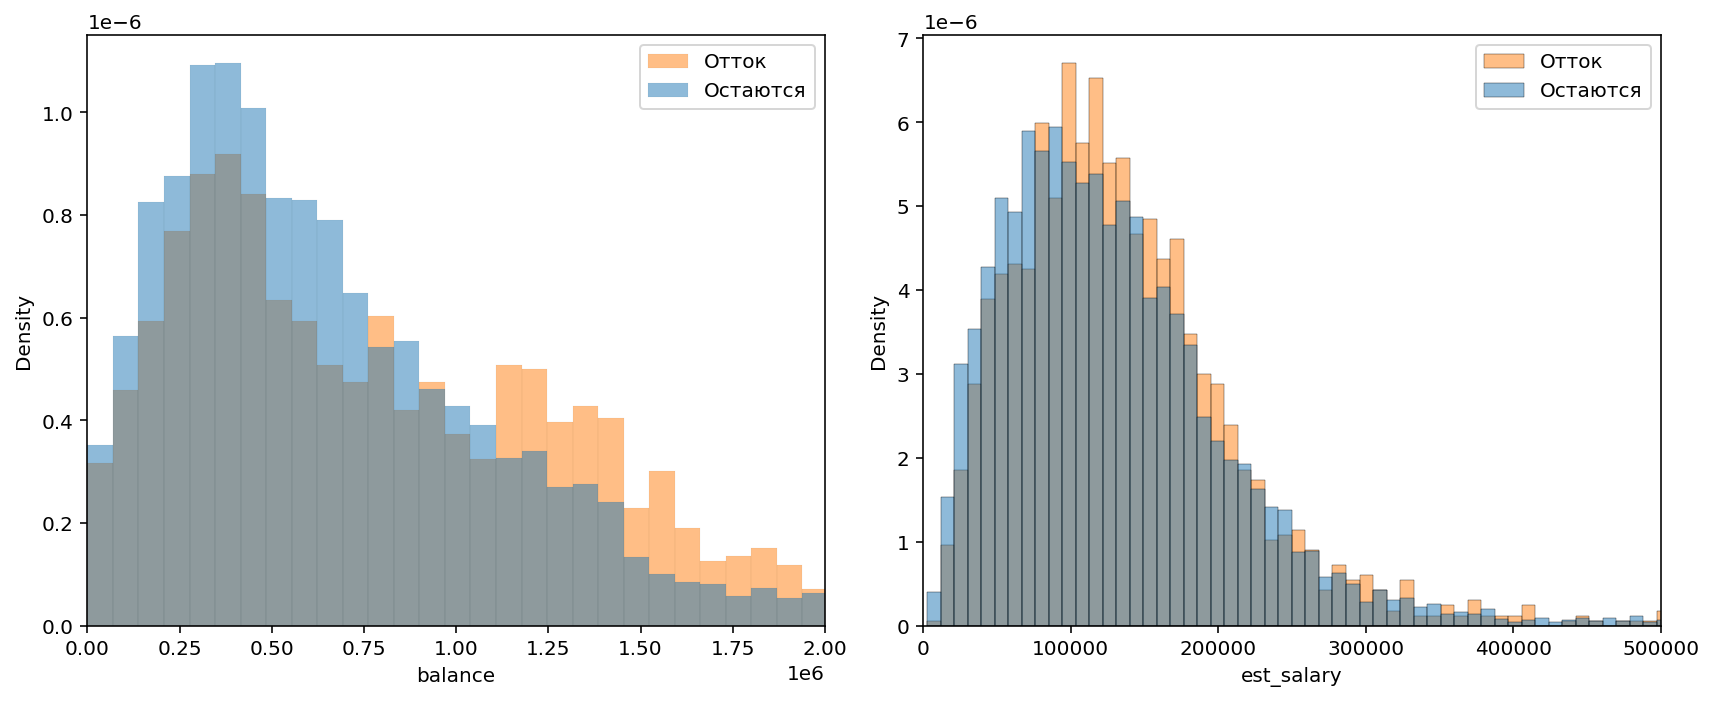

In [25]:
plt.figure(figsize=(12,5))

sns.histplot(x='balance', 
             data=df_pred, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 1))
plt.legend(labels=['Отток', 'Остаются'])
plt.xlim(0,2000000)

sns.histplot(x='est_salary', 
             data=df_pred, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 2))
plt.legend(labels=['Отток', 'Остаются'])
plt.xlim(0,500000)

plt.tight_layout()
plt.show()

Также сравним распределение баланса до и после обработки пропусков.

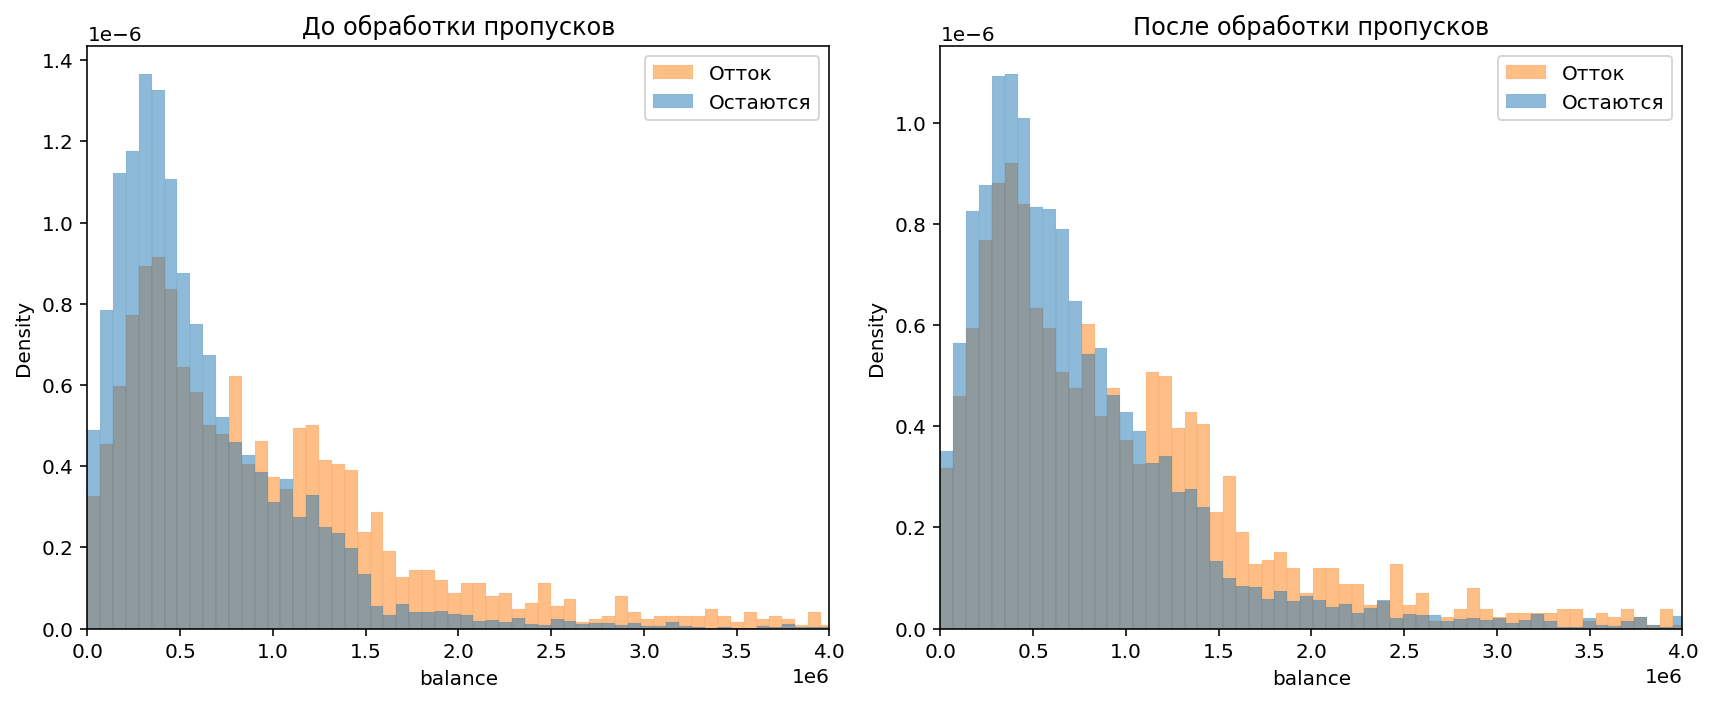

In [26]:
plt.figure(figsize=(12,5))

sns.histplot(x='balance', 
             data=df, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 1)).set(title='До обработки пропусков')
plt.legend(labels=['Отток', 'Остаются'])
plt.xlim(0,4000000)

sns.histplot(x='balance', 
             data=df_pred, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 2)).set(title='После обработки пропусков')
plt.legend(labels=['Отток', 'Остаются'])
plt.xlim(0,4000000)

plt.tight_layout()
plt.show()

Сравним средние и модальные значения признаков для отточных и неотточных клиентов. Для признаков `equity` и `products` посчитаем моду, для остальных - среднее.

In [27]:
def portrait(features, statistic):
    if statistic == 'median':
        result = pd.DataFrame(columns = ['Отток'], 
             data = df_pred.query('churn == 1')[features]
             .median()).round(2) \
        .join(pd.DataFrame(columns = ['Остаются'], 
             data = df_pred.query('churn == 0')[features]
             .median()).round(2))
    elif statistic == 'mean':
        result = pd.DataFrame(columns = ['Отток'], 
             data = df_pred.query('churn == 1')[features]
             .mean()).round(2) \
        .join(pd.DataFrame(columns = ['Остаются'], 
             data = df_pred.query('churn == 0')[features]
             .mean()).round(2))
    else:
        result = pd.DataFrame(columns = ['Отток'], 
             data = [mode(df_pred.query('churn == 1')[i]) for i in features],
             index=features) \
        .join(pd.DataFrame(columns = ['Остаются'], 
             data = [mode(df_pred.query('churn == 0')[i]) for i in features],
             index=features))
    return result

In [28]:
col_for_median = df_pred.columns.difference(['equity', 'products']).tolist()
temp_1 = portrait(col_for_median, 'mean')
temp_2 = portrait(['equity', 'products'], 'mode')
pd.concat([temp_1,temp_2])

,Отток,Остаются
age,41.40,43.16
balance,1139124.01,960465.09
churn,1.00,0.00
city_Ростов,0.15,0.14
city_Рыбинск,0.24,0.27
city_Ярославль,0.62,0.59
credit_card,0.55,0.71
est_salary,148199.98,147764.05
gender,0.65,0.47
last_activity,0.70,0.48


Как видим, по ряду признаков есть различия. Следует отметить, что среди клиентов с отсутствующим балансом практически нет отточных. Ранее было сформулировано предположение, что такие клиенты пользуются в основном только кредитной карты, поэтому у них нет расчетного счета в банке. Посмотрим на графике, как соотносится количество продуктов с наличием кредитной карты у таких клиентов.

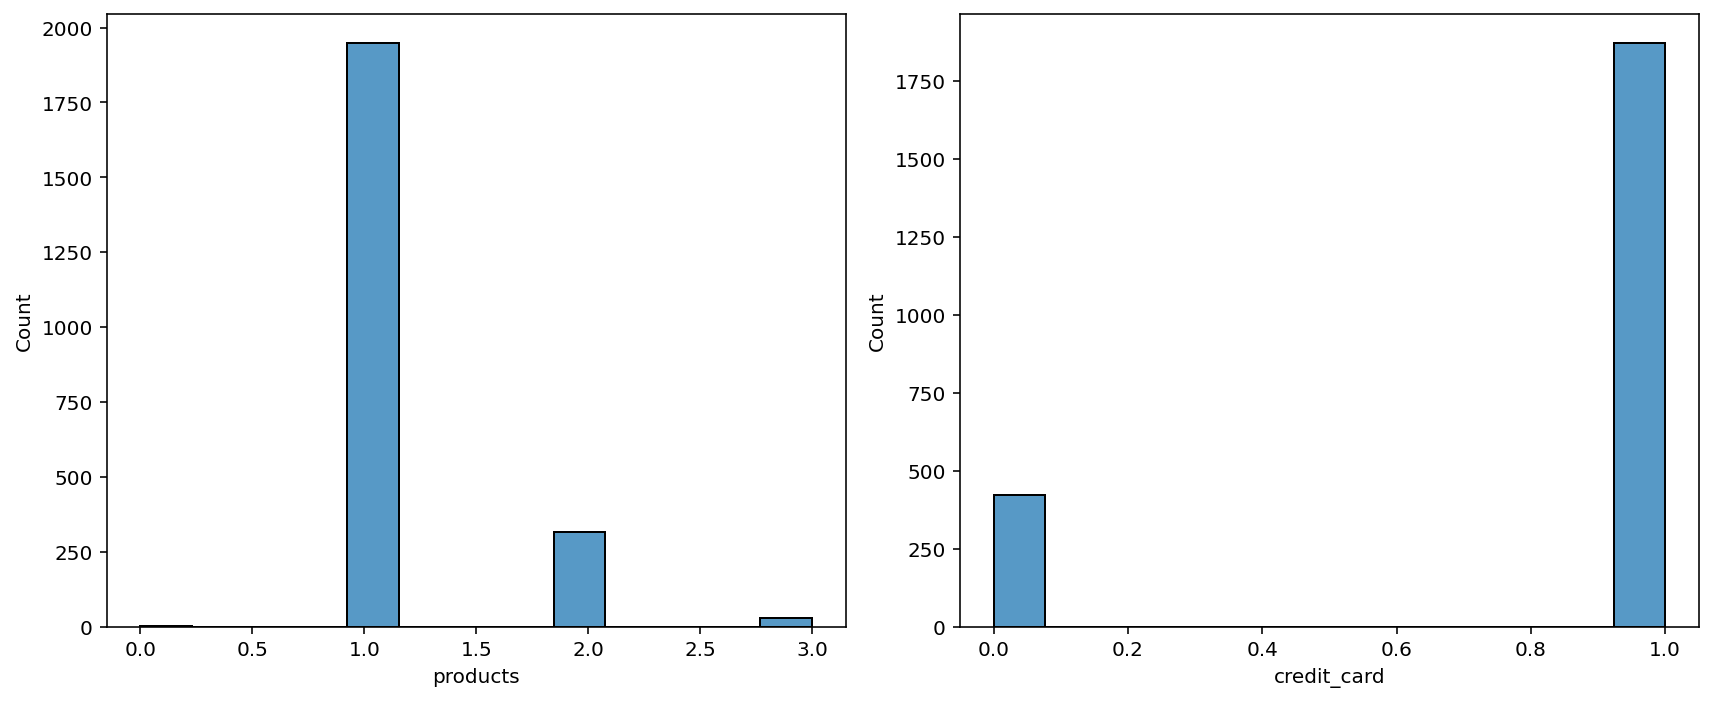

In [29]:
plt.figure(figsize=(12,5))
sns.histplot(x='products', data=df_pred.query('missing_balance == 1'), ax=plt.subplot(1,2,1))
sns.histplot(x='credit_card', data=df_pred.query('missing_balance == 1'), ax=plt.subplot(1,2,2))
plt.tight_layout()
plt.show()

Судя по всему, предположение верно - чаще всего у таких клиентов только кредитная карта.

Можно выделить следующие отточные границы:
- score >= 840 and score <= 910,
- equity >= 3, 
- balance >= 1130000, 
- products >= 2, 
- credit_card == 0, 
- missing_balance == 0, 
- (age >= 25 and age <= 34) or (age >= 52 and age <= 60)

### Проверка стат.гипотез

Проверим, являются ли статистически значимыми различия в доходе и наличием кредитной карты.

Для проверки применим t-тест. Обоснование выбора:
- генеральные совокупности являются независимыми друг от друга;
- выборочные средние распределены нормально согласно ЦПТ;
- поскольку размеры выборок отличаются и нет оснований полагать, что дисперсии генеральных совокупностей равны, будем использовать параметр `equal_var = False`

#### Проверка гипотезы о различии дохода между теми клиентами, которые ушли и теми, которые остались.

Сформулируем гипотезы:
- Н0 - средние доходы отточных и неотточных клиентов равны;
- Н1 - средние доходы отточных и неотточных клиентов различаются

In [30]:
alpha = .05

result = st.ttest_ind(
    df_pred.query('churn == 1')['est_salary'], 
    df_pred.query('churn == 0')['est_salary'], 
    equal_var = False
)

print(result.pvalue)

0.8943768412021069


Вероятность получить наблюдаемый или более далекий результат, при условии, что нулевая гипотеза равна, достаточно высокая. С вероятностью 95% можно утверждать, что средние доходы отточных и неотточных клиентов равны. Утверждение не противоречит полученным в таблице выше данным - доходы обеих групп практически равны, разница не является статистически значимой. 

#### Проверка критерием Манна-Уитни

In [31]:
alpha = .05

result = st.mannwhitneyu(
    df_pred.query('churn == 1')['est_salary'], 
    df_pred.query('churn == 0')['est_salary'])

print(result.pvalue)

0.0002499111605569152


Тест Манна-Уитни показал другой результат в связи с наличием выбросов. Данный тест - непараметрический, не подвержен влиянию выбросов. Поэтому вывод изменился - отвергаем нулевую гипотезу, разница в доходах является статистически значимой.

#### Проверка гипотезы о различии в пользовании кредитной карты между отточными и неотточными клиентами

Сформулируем гипотезы:
- Н0 - доли отточных и неотточных клиентов, имующие кредитную карту, не отличаются;
- Н1 - доля отточных клиентов, имеющих кредитную карту, меньше доли неотточных клиентов

In [32]:
alpha = .05

result = st.ttest_ind(
    df_pred.query('churn == 1')['credit_card'], 
    df_pred.query('churn == 0')['credit_card'], 
    equal_var = False,
    alternative = 'less'
)

print(result.pvalue)

1.8094723805582136e-35


Вероятность того, что доли не отличаются, крайне мала. Можно утверждать, что клиенты, ушедшие в отток, реже пользуются кредитной картой. В таблице выше также видно, что лояльные клиенты чаще имеют кредитную карту.

## Выделение клиентских сегментов
<a id='4'></a>

Обозначим ключевые признаки, влияющие на отток:
- products
- equity
- credit_card
- missing_balance (отдельно выделим сегменты без этой фичи)

При построении сегментов также учтем следующие признаки (в связи с явными отличиями между группами клиентов):
- score
- age
- balance

In [33]:
# отточные границы по признакам
queries = {'score': 'score >= 840 and score <= 910',
          'equity': 'equity >= 3', 
          'balance': 'balance >= 1130000', 
          'products': 'products >= 2', 
          'credit_card': 'credit_card == 0', 
          'missing_balance': 'missing_balance == 0', 
           'age': '((age >= 25 and age <= 34) or (age >= 52 and age <= 60))'}

In [34]:
def segmentation(features):
    
    '''
    Функция принимает признаки features, которые будем комбинировать в дальнейшем 
    для нахождения оптимального сочетания. Возвращает массивы для дальнейшего построения датафрейма:
    keys - перечисляются признаки в формате 'equity + balance + products', чтобы были понятно,
    какие признаки комбинируем
    size - число клиентов, отобранных по признакам
    churn_rate - уровень оттока по таким клиентам 
    churn_rate_other - уровень оттока по клиентам, которые не попадают в отточные границы признаков
    '''
    
    values = [queries[i] for i in features]
    values = ' and '.join(values)
    keys = ' + '.join(features)
    new_query = {keys: values}
    
    size = df_pred.query(values).shape[0]
    churn_rate = round(df_pred.query(values)['churn'].mean(), 2)
    churn_index = df_pred.query(values).index
    staying_index = df_pred.index.difference(churn_index)
    churn_rate_other = round(df_pred.loc[staying_index, 'churn'].mean(), 2)
    
    return keys, size, churn_rate, churn_rate_other

In [35]:
def get_segments(number_of_features_to_combine):
    
    '''
    Передаем функции кол-во признаков для комбинирования. 
    Функция перебирает все возможные комбинации признаков из переменной queries.
    По каждой комбинации получаем массивы данных из функции segmentation,
    из которых формируем датафрейм.
    '''

    features = list(queries.keys())
    features_combinations = combinations(features, number_of_features_to_combine)
    list_of_features = [i for i in features_combinations]

    keys, size, churn_rate, churn_rate_other =[],[],[],[]

    for i in list_of_features:
    
        k, s, c_r, c_r_o = segmentation(list(i))
    
        keys.append(k)
        size.append(s)
        churn_rate.append(c_r)
        churn_rate_other.append(c_r_o)

    result = pd.DataFrame({
        'Признак': keys,
        'Число_клиентов': size,
        'Отток': churn_rate,
        'Отток_вне_признака': churn_rate_other
    })
    
    return result

In [36]:
def segments_scoring(result):
    
    '''
    Функция принимает датафрейм со всеми комбинациями признаков, 
    полученных функцией get_segments.
    Столбцам присваивается рейтинг от 1 до 5 с учетом поправочного коэффициента
    (подобран экспериментально, отражает примерный вес показателя).
    '''
    
    result['clients_score'] = pd.qcut(
        result['Число_клиентов'], 
        q=5, labels=[i*0.9 for i in range(1,6)])
    result['churn_score'] = pd.cut(
        result['Отток'], 
        bins=5, labels=[i*1.5 for i in range(1,6)])
    result['churn_other_score'] = pd.cut(
        result['Отток_вне_признака'], 
        bins=5, labels=[-i*0.5 for i in range(1,6)])
    result['score'] = result[['clients_score', 'churn_score', 'churn_other_score']].sum(axis=1)
    
    return result

Просегментируем клиентов с комбинациями от 2 до 5 признаков (с учетом фичи `missing_balance`) и выведем топ-5 сегментов с каждой итерации.

In [37]:
total_result_with_mb=[]
for i in range(2,6):
    result = get_segments(i)
    seg_scoring = segments_scoring(result)
    display(seg_scoring.sort_values('score', ascending=False).head())
    total_result_with_mb.append(seg_scoring)

,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
13,balance + missing_balance,1532,0.42,0.14,1.8,7.5,-2.0,7.3
11,balance + products,1506,0.41,0.14,1.8,7.5,-2.0,7.3
6,equity + balance,1435,0.42,0.14,1.8,7.5,-2.0,7.3
20,missing_balance + age,3201,0.31,0.12,4.5,3.0,-1.5,6.0
16,products + missing_balance,6314,0.25,0.06,4.5,1.5,-0.5,5.5


,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
17,equity + balance + missing_balance,1435,0.42,0.14,3.6,4.5,-2.0,6.1
14,score + missing_balance + age,1287,0.41,0.15,3.6,4.5,-2.0,6.1
26,balance + products + missing_balance,1380,0.44,0.14,3.6,4.5,-2.0,6.1
15,equity + balance + products,1296,0.45,0.14,3.6,4.5,-2.0,6.1
3,score + equity + missing_balance,2405,0.34,0.13,4.5,3.0,-1.5,6.0


,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
32,balance + products + missing_balance + age,482,0.60,0.16,1.8,7.5,-1.5,7.8
0,score + equity + balance + products,545,0.54,0.16,2.7,6.0,-1.5,7.2
19,score + credit_card + missing_balance + age,512,0.54,0.16,2.7,6.0,-1.5,7.2
17,score + products + credit_card + age,509,0.54,0.16,2.7,6.0,-1.5,7.2
21,equity + balance + products + missing_balance,1296,0.45,0.14,4.5,3.0,-0.5,7.0


,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
17,equity + balance + products + missing_balance + age,451,0.59,0.16,3.6,4.5,-1.0,7.1
2,score + equity + balance + products + age,190,0.68,0.17,0.9,7.5,-2.0,6.4
12,score + balance + products + missing_balance + age,204,0.69,0.17,0.9,7.5,-2.0,6.4
9,score + equity + credit_card + missing_balance + age,433,0.56,0.17,3.6,4.5,-2.0,6.1
4,score + equity + balance + credit_card + age,125,0.72,0.18,0.9,7.5,-2.5,5.9


Также посмотрим на топ-5 сегменты без учета фичи `missing_balance`.

In [38]:
queries = {'score': 'score >= 840 and score <= 910',
          'equity': 'equity >= 3', 
          'balance': 'balance >= 1130000', 
          'products': 'products >= 2', 
          'credit_card': 'credit_card == 0', 
           'age': '((age >= 25 and age <= 34) or (age >= 52 and age <= 60))'}

In [39]:
total_result_without_mb=[]
for i in range(2,6):
    result = get_segments(i)
    seg_scoring = segments_scoring(result)
    display(seg_scoring.sort_values('score', ascending=False).head())
    total_result_without_mb.append(seg_scoring)

,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
9,balance + products,1506,0.41,0.14,2.7,7.5,-2.0,8.2
5,equity + balance,1435,0.42,0.14,1.8,7.5,-2.0,7.3
0,score + equity,2405,0.34,0.13,3.6,4.5,-1.5,6.6
8,equity + age,2336,0.35,0.13,3.6,4.5,-1.5,6.6
13,products + age,2778,0.31,0.13,4.5,3.0,-1.5,6.0


,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
10,equity + balance + products,1296,0.45,0.14,4.5,4.5,-0.5,8.5
17,balance + products + age,533,0.54,0.16,1.8,7.5,-2.0,7.3
12,equity + balance + age,492,0.57,0.16,0.9,7.5,-2.0,6.4
15,equity + credit_card + age,901,0.46,0.15,2.7,4.5,-1.0,6.2
18,balance + credit_card + age,345,0.54,0.17,0.9,7.5,-2.5,5.9


,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
11,equity + balance + products + age,451,0.59,0.16,2.7,6.0,-1.0,7.7
12,equity + balance + credit_card + age,283,0.63,0.17,1.8,7.5,-2.0,7.3
0,score + equity + balance + products,545,0.54,0.16,3.6,4.5,-1.0,7.1
9,score + products + credit_card + age,509,0.54,0.16,3.6,4.5,-1.0,7.1
2,score + equity + balance + age,209,0.65,0.17,0.9,7.5,-2.0,6.4


,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
1,score + equity + balance + products + age,190,0.68,0.17,1.8,6.0,-0.5,7.3
5,equity + balance + products + credit_card + age,281,0.63,0.17,2.7,4.5,-0.5,6.7
2,score + equity + balance + credit_card + age,125,0.72,0.18,0.9,7.5,-2.5,5.9
4,score + balance + products + credit_card + age,135,0.70,0.18,0.9,7.5,-2.5,5.9
3,score + equity + products + credit_card + age,425,0.57,0.17,4.5,1.5,-0.5,5.5


Отберем наиболее значимые сегменты с точки зрения числа клиентов и уровня оттока (с признаком `missing_balance` и без):

In [40]:
top_segments = pd.concat([total_result_with_mb[2].loc[21], 
                          total_result_with_mb[1].loc[14], 
                          total_result_without_mb[1].loc[15]],
                        axis=1).T.reset_index(drop=True)
top_segments

,Признак,Число_клиентов,Отток,Отток_вне_признака,clients_score,churn_score,churn_other_score,score
0,equity + balance + products + missing_balance,1296,0.45,0.14,4.5,3.0,-0.5,7.0
1,score + missing_balance + age,1287,0.41,0.15,3.6,4.5,-2.0,6.1
2,equity + credit_card + age,901,0.46,0.15,2.7,4.5,-1.0,6.2


#### Характеристики отточных сегментов

Сегмент 0:
- оценка собственности не менее 3
- сумма на балансе не менее 1.13 млн
- количество продуктов не менее 2
- нет метки отсутствующего баланса

Сегмент 1:
- баллы кредитного скоринга от 840 до 910
- нет метки отсутствующего баланса
- возраст от 25-34 либо 52-60

Сегмент 2:
- оценка собственности не менее 3
- нет кредитной карты
- возраст от 25-34 либо 52-60

## Рекомендации по удержанию клиентов
<a id='5'></a>

В целом можно сделать вывод, что оттоку в большей степени подвержены более состоятельные клиенты. У таких клиентов сумма на балансе выше среднего, неплохой кредитный скоринг, пользуются бОльшим количеством продуктов, более высокая оценка активов. Необходимо понять причину появления пропусков в балансе. Анализ проводился с предположением, что пропуск в балансе означает отсутствие расчетного счета. При этом у таких клиентов, как правило, 1 продукт и чаще всего это кредитная карта. Среди таких клиентов практически нет отточных.

В разрезе сегментов можно дать следующие рекомендации:

Сегмент 0:
- рекламировать продукты по сбережению собственности (например, страхование) либо инвестиционные программы (в связи с средними/высокими оценками собственности);
- предложить повышенные процентные ставки по депозитам при сумме свыше 1 млн руб либо инвестиционные программы (в связи с большим оттоком клиентов с крупной суммой на счете)
- пересмотреть перечень предлагаемых продуктов (вероятно клиенты набирают продукты, которые по факту им не интересны либо не удовлетворяют качеством, и в результате уходят. У более лояльных клиентов не более 2 продуктов, среди которых, скорее всего, есть кредитная карта)

Сегмент 1:
- предложить программы кредитования/кредитные карты (учитывая хороший кредитный скоринг и наличие денег на балансе)

Сегмент 2:
- также прорекламировать кредитные продукты, в т.ч. предполагающие принятие залога, и кредитные карты. 